In [ ]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Import libraries for analysis,visualizing and computing the dataset.**

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Aquisition and Data Pre-processing.**

In Data Aquisition where we aquire the data from relevant source, in this project we have taken data from John Hopkin, where in Data Pre-processing we removing Irrelevant feature and select relevant feature as from the dataset we extracted confirmed cases for Top 10 countries as relevant feature.

In [2]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv',parse_dates=['Date'])# read the csv file and upload in an variable.

In [3]:
dataframe ['Province/State']=dataframe['Province/State'].fillna('')#fill the Na value with space.
dataframe

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,33.000000,65.000000,2020-01-22,0,0,0
1,,Albania,41.153300,20.168300,2020-01-22,0,0,0
2,,Algeria,28.033900,1.659600,2020-01-22,0,0,0
3,,Andorra,42.506300,1.521800,2020-01-22,0,0,0
4,,Angola,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
32060,,Sao Tome and Principe,0.186360,6.613081,2020-05-21,251,8,4
32061,,Yemen,15.552727,48.516388,2020-05-21,197,33,0
32062,,Comoros,-11.645500,43.333300,2020-05-21,34,1,8
32063,,Tajikistan,38.861034,71.276093,2020-05-21,2350,44,0


In [4]:
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)# rename the column (Country/Region as Country and Province/State as State).

In [5]:
dth = dataframe.fillna('').groupby('Country')[['Confirmed','Deaths','Recovered']].max()# extract the values of Confirmed , Deaths ,Recovered with respect to    
dth=dth.sort_values(by=['Confirmed','Deaths'],ascending=False)# sort out the values with respect to Confirmed and Death.
dth=dth.head(10)# show just top 10 values in output.
dth

,Confirmed,Deaths,Recovered
Country,,,
US,1577147,94702,298418
Russia,317554,3099,92681
Brazil,310087,20047,125960
United Kingdom,250908,36042,508
Spain,233037,27940,150376
Italy,228006,32486,134560
France,179306,28193,62216
Germany,179021,8203,158087
Turkey,153548,4249,114990


Data Transformation

In Data Transformation we analysis and check the stationarity of confirmed cases data from our given dataframe by method of visualizing means Rolling Statistic and by statistic method using Augmented Dickey-Fuller test.

In [6]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Deaths'):
    CDR=dataframe.loc[(dataframe['Country']==country)]  
    CDR=CDR[['Date',case]]
    CDR=CDR.set_index('Date')
    CDR.astype('int64')
    a=len(CDR.loc[(CDR['Deaths']>=10)])
    CDR=CDR[-a:]
    return (CDR.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Deaths'):
    CDR=dataframe.loc[(dataframe['Country']==country)]  
    CDR=CDR[['Date',case]]
    CDR=CDR.set_index('Date')
    CDR.astype('int64')
    a=len(CDR.loc[(CDR['Deaths']>=10)])
    CDR=CDR[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(CDR.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(CDR[case], label='Deaths')
    plt.plot(CDR.rolling(window=7,center=False).std(),label='Rolling std')
    #plt.plot('Deaths', label='First Line')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

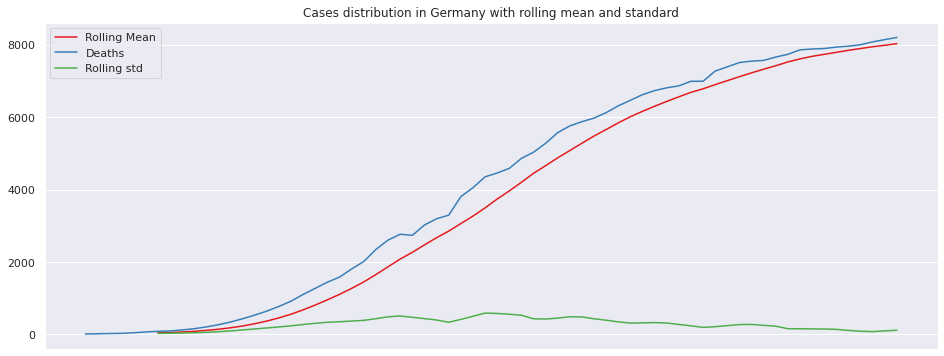

In [7]:
Gtest=roll('Germany')
rollPlot('Germany')

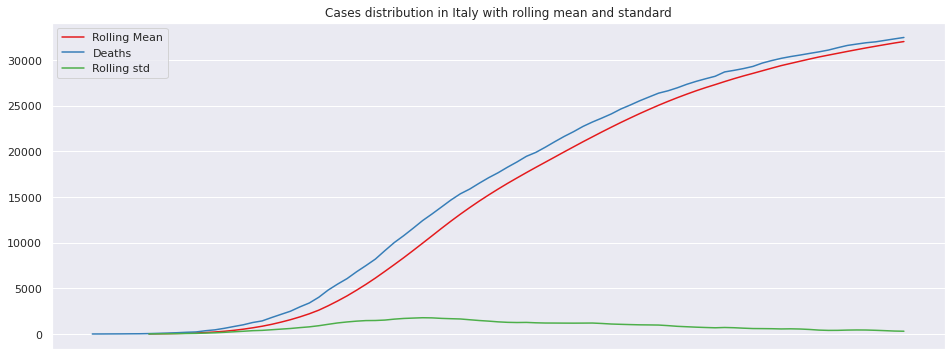

In [8]:
Itest=roll('Italy')
rollPlot('Italy')

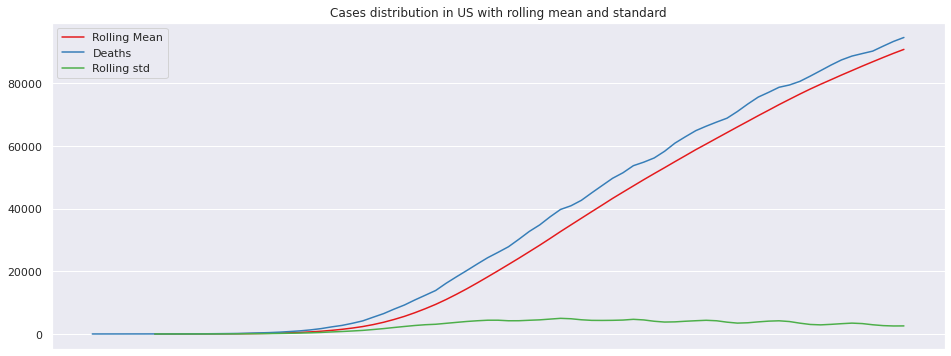

In [9]:
UStest=roll('US')
rollPlot('US')

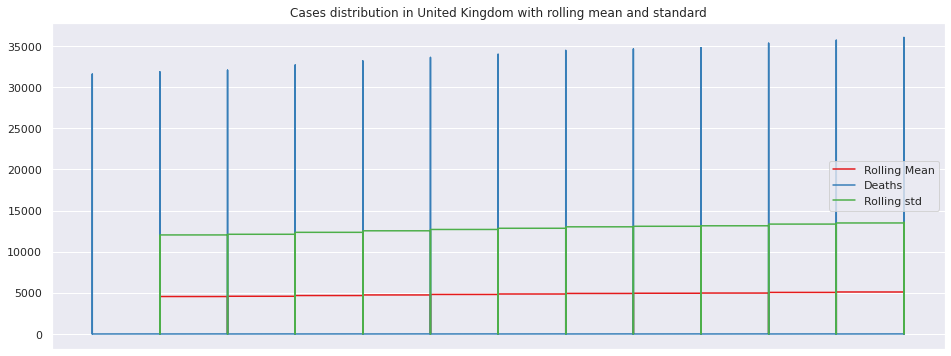

In [10]:
Uktest=roll('United Kingdom')
rollPlot('United Kingdom')

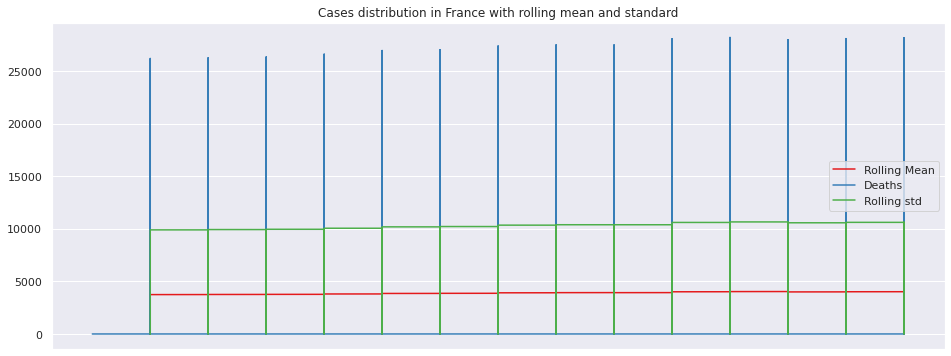

In [11]:
Ftest=roll('France')
rollPlot('France')

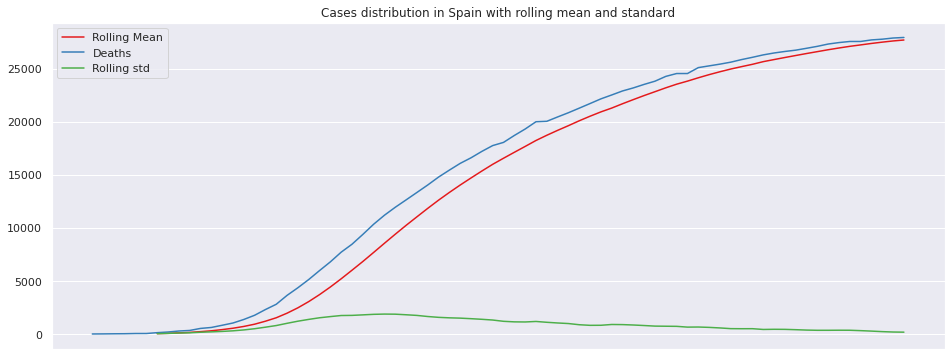

In [12]:
Sptest=roll('Spain')
rollPlot('Spain')

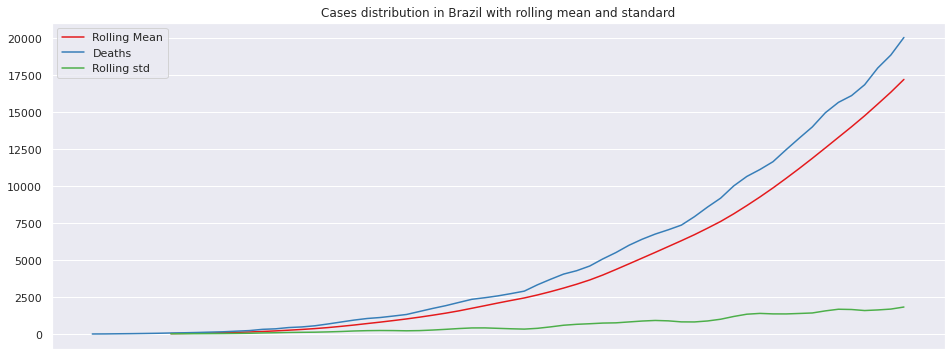

In [13]:
Bztest=roll('Brazil')
rollPlot('Brazil')

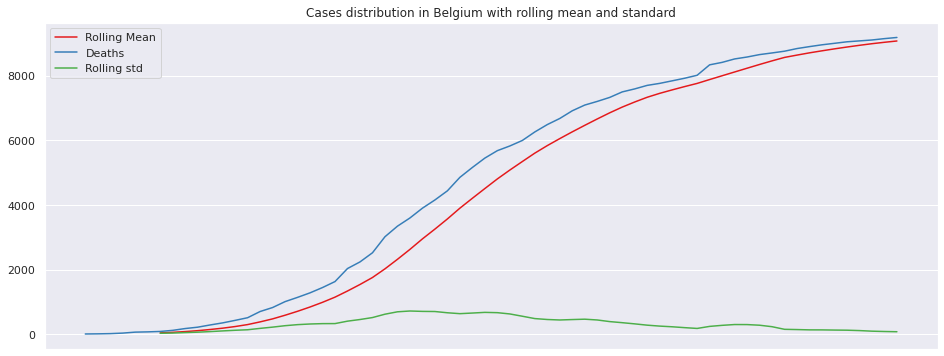

In [14]:
Bltest=roll('Belgium')
rollPlot('Belgium')

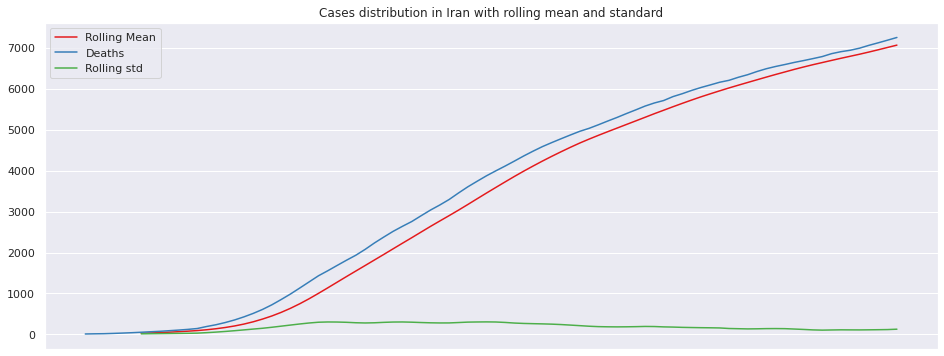

In [15]:
Irtest=roll('Iran')
rollPlot('Iran')

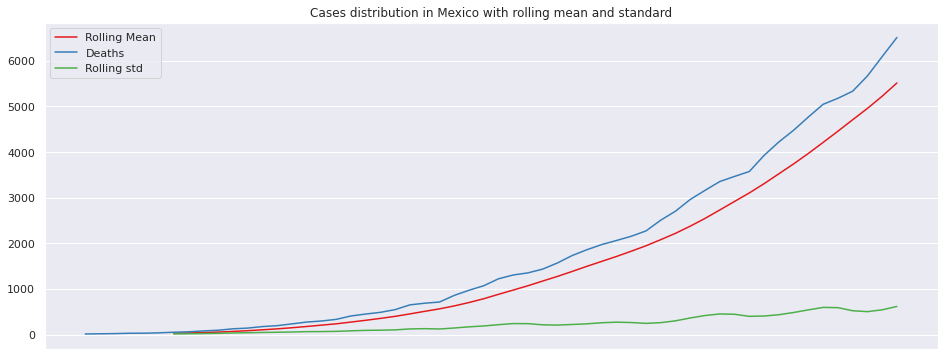

In [16]:
Mxtest=roll('Mexico')
rollPlot('Mexico')

**Modeling**

Modeling of Time series data different models are used namely AR,MA,Sarima, Arima ,here we have use Arima model which consist of three component (p,q,d),before this the dataframe has been splited into train and test data, then for finding the best parameter of (p d q) we use grid search method.

In [17]:
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_squared_error,mean_absolute_error

**For Deaths Cases Germany**

Predicted values : [7616.64006707 7671.43621551 7761.8633101  7860.8660943  7972.36959755
 8062.7594309  8134.85335376 8202.57606246 8274.24853297 8368.85306069]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   53
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -236.237
Method:                       css-mle   S.D. of innovations             19.515
Date:                Sun, 27 Sep 2020   AIC                            490.474
Time:                        20:56:21   BIC                            508.206
Sample:                    03-20-2020   HQIC                           497.293
                         - 05-11-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2741      2.843 

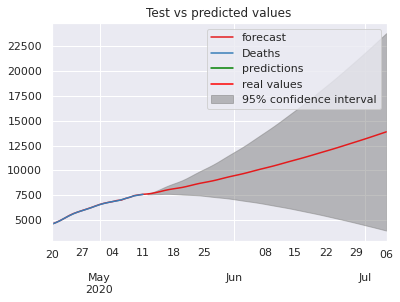

In [18]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.85)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Gtest)
prediction=arima(train,test)

**Death Cases for Italy**

Predicted values : [30820.45454413 30984.61075946 31133.72450405 31266.73734944
 31390.0918283  31507.45857521 31620.75442594 31732.42147048
 31844.99550526]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   73
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -324.432
Method:                       css-mle   S.D. of innovations             18.816
Date:                Sun, 27 Sep 2020   AIC                            672.863
Time:                        20:56:50   BIC                            700.349
Sample:                    03-01-2020   HQIC                           683.817
                         - 05-12-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4806      8.837     

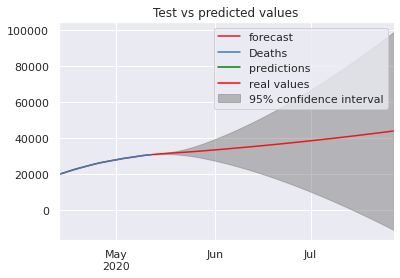

In [19]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.90)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Itest)
prediction=arima(train,test)

**Death Cases US**

Predicted values : [83212.32273366 84815.55812248 86212.95721952 87411.53461754
 88399.03874542 89332.58378746 90417.34857195 91618.03292218]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   66
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -383.369
Method:                       css-mle   S.D. of innovations             78.068
Date:                Sun, 27 Sep 2020   AIC                            782.739
Time:                        20:57:02   BIC                            800.256
Sample:                    03-09-2020   HQIC                           789.661
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9166     38.566      0.076      0.94

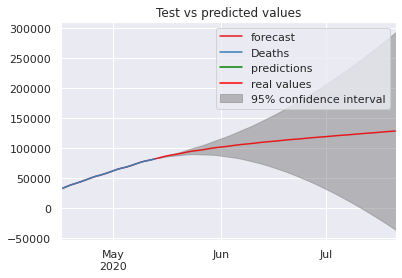

In [20]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.90)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(UStest)
prediction=arima(train,test)

**Deaths Cases Uk**

In [21]:


#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.90)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Uktest)
prediction=arima(train,test)

Predicted values : [8187.79933531 7324.1265901   705.43178012  752.71682215 1307.76078165
 -146.42501714 4425.62172843 4476.57065049 3442.11700932 5876.62230369
 2732.67595405 2382.15915073 3998.93053317 1334.86749775]
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  120
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1092.272
Method:                       css-mle   S.D. of innovations           2044.231
Date:                Sun, 27 Sep 2020   AIC                           2202.544
Time:                        20:57:17   BIC                           2227.631
Sample:                             1   HQIC                          2212.732
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

**Deaths Cases France**

In [22]:


#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.94)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Ftest)
prediction=arima(train,test)

Predicted values : [ 6246.02065752   638.17056892  -637.59079244 -1310.72639617
 -3021.07874232  1001.31220355  2731.68330969  3723.85254162
  7236.15603314  5326.50630537]
                              ARMA Model Results                              
Dep. Variable:                 Deaths   No. Observations:                  142
Model:                     ARMA(4, 3)   Log Likelihood               -1233.761
Method:                       css-mle   S.D. of innovations           1371.025
Date:                Sun, 27 Sep 2020   AIC                           2485.522
Time:                        20:57:41   BIC                           2512.125
Sample:                             0   HQIC                          2496.333
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2473.3415     24.18

ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>

**Death Cases Spain**

Predicted values : [26570.22956214 26750.68452121 26918.49958915 27098.37436557
 27278.07971015 27452.04530828 27631.81249619 27816.2530964
 27999.78105816 28186.03466286 28376.76816215]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   60
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -303.691
Method:                       css-mle   S.D. of innovations             37.379
Date:                Sun, 27 Sep 2020   AIC                            621.382
Time:                        21:02:01   BIC                            636.043
Sample:                    03-12-2020   HQIC                           627.117
                         - 05-10-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const        

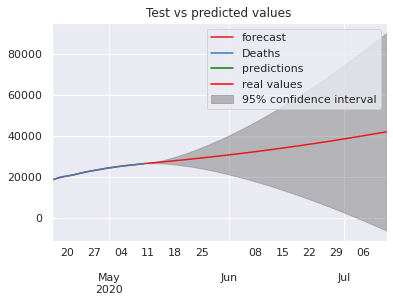

In [27]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.85)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Sptest)
prediction=arima(train,test)

**Death cases Brazil**

Predicted values : [12794.44821668 13506.11348669 14233.0922617  14961.86930794
 15692.56971785 16423.74105766 17171.18828988 17937.98426552]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   50
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -224.178
Method:                       css-mle   S.D. of innovations             20.345
Date:                Sun, 27 Sep 2020   AIC                            462.357
Time:                        20:59:11   BIC                            475.741
Sample:                    03-25-2020   HQIC                           467.453
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.4195      3.158      4.250      0.00

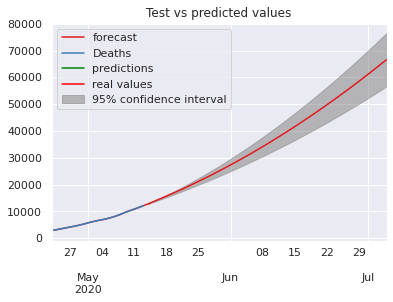

In [23]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.88)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Bztest)
prediction=arima(train,test)

Death Cases Belgium

Predicted values : [8683.2389905  8758.79620433 8838.42580055 8919.89207412 9002.65633716
 9086.71858969 9172.0788317  9258.73706319 9346.69328416 9435.94749461]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   51
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -226.329
Method:                       css-mle   S.D. of innovations             18.884
Date:                Sun, 27 Sep 2020   AIC                            464.658
Time:                        20:59:36   BIC                            476.249
Sample:                    03-22-2020   HQIC                           469.087
                         - 05-11-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2980      4.891 

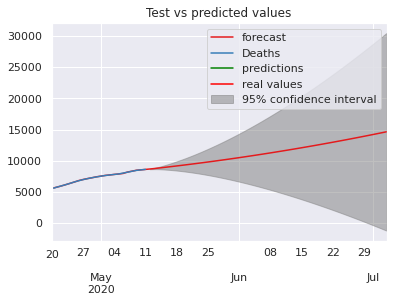

In [24]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.85)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Bltest)
prediction=arima(train,test)

**Death Cases Iran**

Predicted values : [6511.92609391 6573.37519517 6632.62883165 6692.63006929 6753.3789081
 6814.87534808 6877.11938922 6940.11103153 7003.850275   7068.33711964
 7133.57156545 7199.55361242 7266.28326056]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   70
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -181.298
Method:                       css-mle   S.D. of innovations              3.002
Date:                Sun, 27 Sep 2020   AIC                            372.597
Time:                        20:59:54   BIC                            383.839
Sample:                    02-29-2020   HQIC                           377.062
                         - 05-08-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

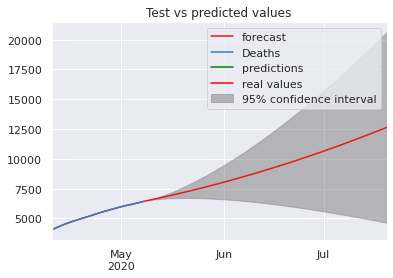

In [25]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.85)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Irtest)
prediction=arima(train,test)

**Deaths Cases Mexico**

Predicted values : [4036.72218343 4296.25920618 4534.33167001 4756.72254277 4974.21536906
 5198.37894793 5449.47835417 5720.9548924 ]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   43
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -166.092
Method:                       css-mle   S.D. of innovations             11.201
Date:                Sun, 27 Sep 2020   AIC                            344.184
Time:                        21:00:03   BIC                            354.751
Sample:                    04-01-2020   HQIC                           348.081
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.0211      0.929      5.406      0.000       

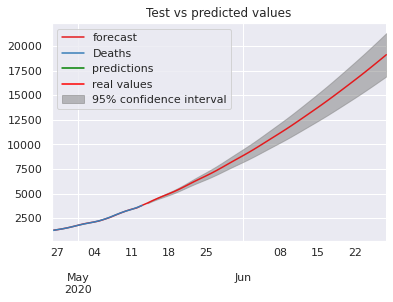

In [26]:

#Mean absolute percentage error
def mape(x1, x_pred): 
    x1, x_pred = np.array(x1), np.array(x_pred)
    return np.mean(np.abs((x1 - x_pred) / x1)) * 100

def split(CDR):
    #splitting 85%/15% because of little amount of data
    size = int(len(CDR) * 0.85)
    train= CDR[:size]
    test = CDR[size:]
    return(train,test)


#Arima modeling for CDR
def arima(CDR,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(CDR, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(CDR, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(CDR) * 0.6), end=int(len(CDR) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    #f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(Mxtest)
prediction=arima(train,test)

**Checking for similarity(Trend) between Germany and Italy in Death cases using number of predicted values from model result.**

In [ ]:

from scipy.special import rel_entr
# defining distributions
Germany = [7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069]
Italy = [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576]
# calculating (Germany || Italy)
kl_Germany_Italy = rel_entr(Germany, Italy)
print('KL(Germany || Italy): %.3f nats' % sum(kl_Germany_Italy))
# calculating (Italy || Germany)
kl_Italy_Germany = rel_entr(Italy,Germany)
print('KL(Italy || Germany): %.3f nats' % sum(kl_Italy_Germany))

KL(Germany || Italy): -67479.016 nats
KL(Italy || Germany): 267337.231 nats


**Hence,Kl divergence satisfies the condition that KL(Germany || Italy)!=KL(Italy || Germany)**

In [ ]:

from scipy.spatial.distance import jensenshannon
from numpy import asarray
# defining distributions
Germany = asarray([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069])
Italy = asarray([31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])
# calculating (Germany || Italy)
JS_Germany_Italy = jensenshannon(Germany, Italy,base=2)
print('JS(Germany || Italy): %.3f nats' % JS_Germany_Italy)
# calculating (Italy || Germany)
JS_Italy_Germany = jensenshannon(Italy,Germany,base=2)
print('JS(Italy || Germany): %.3f nats' % JS_Italy_Germany)

JS(Germany || Italy): 0.001 nats
JS(Italy || Germany): 0.001 nats


**Hence,JS divergence satisfies the condition that JS(Germany || Italy)==JS(Italy || Germany)**

In [ ]:
from scipy import stats
stats.spearmanr([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069], [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])

np.random.seed(7972)
x2n = np.random.randn(100, 2)
y2n = np.random.randn(100, 2)
stats.spearmanr(x2n)

SpearmanrResult(correlation=0.1438943894389439, pvalue=0.15320623761722527)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = dataframe.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943
#df.loc[(df['Country/Region']==country)]
r, p = stats.pearsonr(dataframe.loc[(Country['Germany'])].dropna(), dataframe.loc[(dataframe['Country/Region(Italy)'])].dropna())
#r, p = stats.pearsonr(df.dropna()['Confirmed'], df.dropna()['Recovered'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
dataframe.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r: -0.1282098089914872


NameError: ignored